In [ ]:
from base64 import b64encode
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import numpy as np
import os
import torch

In [ ]:
# It may take a while...
!wget "https://documents.epfl.ch/groups/c/cv/cvlab-pom-video1/www/campus4-c0.avi"

--2023-02-28 05:05:07--  https://documents.epfl.ch/groups/c/cv/cvlab-pom-video1/www/campus4-c0.avi
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33448124 (32M) [application/octet-stream]
Saving to: ‘campus4-c0.avi’

campus4-c0.avi      100%[===================>]  31.90M   651KB/s    in 44s     

2023-02-28 05:05:52 (739 KB/s) - ‘campus4-c0.avi’ saved [33448124/33448124]



In [ ]:
#@title
def display_video(path):
    '''Display video in Colab.'''
    compressed_path = path.split('.')[0]
    compressed_path = 'compressed_' + compressed_path + '.mp4'

    if os.path.exists(compressed_path):
        os.remove(compressed_path)

    # Convert video
    os.system(f"ffmpeg -i {path} -vcodec libx264 {compressed_path}")

    # Show video
    mp4 = open(compressed_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [ ]:
filename = 'campus4-c0.avi'
display_video(filename)

In [ ]:
# Load model
model = torch.hub.load('ultralytics/yolov5', 'yolov5x',
                       pretrained=True, verbose=False)

# Check if GPU is available
if torch.cuda.is_available():
    model = model.cuda()


/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython>=3.1.30" "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  0%|          | 0.00/166M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
import cv2, os
import numpy as np

def center_distance(x1, y1, x2, y2):
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist, x1, y1, x2, y2

def detect_people_on_frame(img, confidence, distance):
    '''Detect people on a frame and draw the rectangles and lines.'''
    # Your code for object detection

    xyxy = results.xyxy[0].cpu().numpy()  # xyxy are the box coordinates
    xyxy = xyxy[xyxy[:, 4] >= confidence]  # Filter desired confidence
    xyxy = xyxy[xyxy[:, 5] == 0]  # Consider only people
    xyxy = xyxy[:, :4]

    colors = ['green']*len(xyxy)
    for i in range(len(xyxy)):
        for j in range(i+1, len(xyxy)):
            # Calculate distance of the centers
            dist, x1, y1, x2, y2 = center_distance(*xyxy[i], *xyxy[j])
            if dist < distance:
                # If dist < distance, boxes are red and a line is drawn
                colors[i] = 'red'
                colors[j] = 'red'
                img = cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    for i, (x1, y1, x2, y2) in enumerate(xyxy):
        # Draw the boxes
        if colors[i] == 'green':
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    return img

def detect_people_on_video(filename, confidence=0.9, distance=60):
    '''Detect people on a video and draw the rectangles and lines.'''
    # Capture video
    cap = cv2.VideoCapture(filename)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    if os.path.exists('output.avi'):
        os.remove('output.avi')
    out = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

    # Iterate through frames and detect people
    while cap.isOpened():
        # Read a frame
        ret, frame = cap.read()
        # If the frame could not be read, break the loop
        if not ret:
          break
        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Detect people using HOG
        hog = cv2.HOGDescriptor()
        hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
        boxes, weights = hog.detectMultiScale(frame, winStride=(8, 8), padding=(32, 32), scale=1.05)

        # Draw rectangles and lines around detected people
        boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])
        for (xA, yA, xB, yB) in boxes:
          # Check if the detected person is too close
          if yB - yA > distance:
            continue
          cv2.rectangle(frame, (xA, yA), (xB, yB), (0, 255, 0), 2)

        # Write the frame with rectangles and lines to the output video
        out.write(frame)
        # Display the frame
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
          break
    # Release video and close windows
    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [ ]:
detect_people_on_video(filename, confidence=0.5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
display_video('output.avi')

Output hidden; open in https://colab.research.google.com to view.

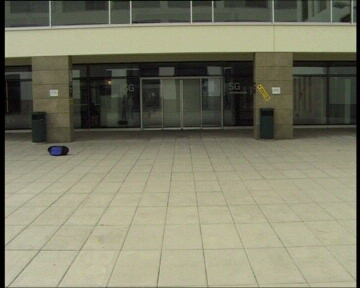

In [ ]:
cap = cv2.VideoCapture(filename)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ret, image = cap.read()
if ret:
    cv2_imshow(image)

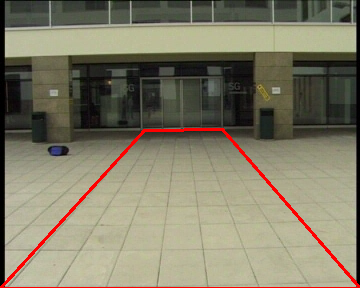

In [ ]:
region = [[222, 129], [width, height], [0, height], [144, 130]]
region = np.array(region, dtype=np.int32).reshape((-1, 1, 2))
region_image = cv2.polylines(image.copy(), [region], True, (0, 0, 255), 2)
cv2_imshow(region_image)

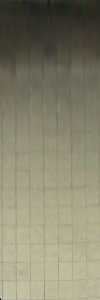

In [ ]:
region = np.array(region.reshape(4, 2), np.float32)
dst = np.float32([[100, 0], [100, 300], [0, 300], [0, 0]])

M = cv2.getPerspectiveTransform(region, dst)
warped = cv2.warpPerspective(image, M, (100, 300))
cv2_imshow(warped)

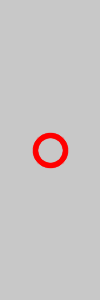

In [ ]:
overlay = np.zeros((300, 100, 3), np.uint8)
overlay[:,:,:] = 200
overlay = cv2.circle(overlay, (50, 150), 15, (0, 0, 255), 3, lineType=cv2.LINE_AA)
cv2_imshow(overlay)

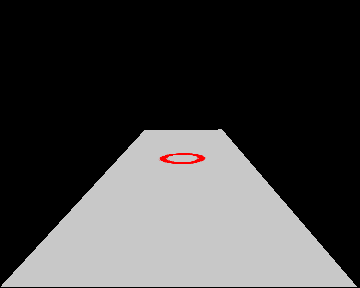

In [ ]:
overlay = cv2.warpPerspective(overlay, M, (width, height), cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
cv2_imshow(overlay)

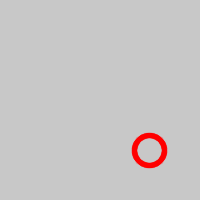

In [ ]:
overlay = np.zeros((200, 200, 3), np.uint8)
overlay[:,:,:] = 200
overlay = cv2.circle(overlay, (50, 150), 15, (0, 0, 255), 3, lineType=cv2.LINE_AA)
overlay = cv2.flip(overlay, 1)
cv2_imshow(overlay)

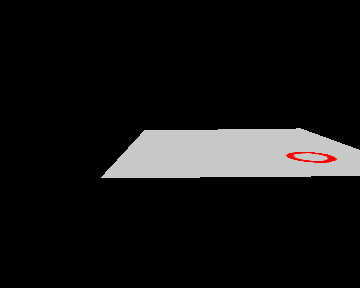

In [ ]:
overlay = cv2.warpPerspective(overlay, M, (width, height), cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
cv2_imshow(overlay)

In [ ]:
def calculate_distance(point1, point2):
    '''Calculate usual distance.'''
    x1, y1 = point1
    x2, y2 = point2
    return np.linalg.norm([x1 - x2, y1 - y2])

In [ ]:
def convert_to_bird(centers, M):
    '''Apply the perpective to the bird's-eye view.'''
    centers = [cv2.perspectiveTransform(np.float32([[center]]), M) for center in centers.copy()]
    centers = [list(center[0, 0]) for center in centers.copy()]
    return centers

In [ ]:
def bird_detect_people_on_frame(img, confidence, distance, width, height,
                                region=None, dst=None):
    results = model([img[:, :, ::-1]])  # Pass the frame through the model and get the boxes

    xyxy = results.xyxy[0].cpu().numpy()  # xyxy are the box coordinates
    #          x1 (pixels)  y1 (pixels)  x2 (pixels)  y2 (pixels)   confidence        class
    # tensor([[7.47613e+02, 4.01168e+01, 1.14978e+03, 7.12016e+02, 8.71210e-01, 0.00000e+00],
    #         [1.17464e+02, 1.96875e+02, 1.00145e+03, 7.11802e+02, 8.08795e-01, 0.00000e+00],
    #         [4.23969e+02, 4.30401e+02, 5.16833e+02, 7.20000e+02, 7.77376e-01, 2.70000e+01],
    #         [9.81310e+02, 3.10712e+02, 1.03111e+03, 4.19273e+02, 2.86850e-01, 2.70000e+01]])

    xyxy = xyxy[xyxy[:, 4] >= confidence]  # Filter desired confidence
    xyxy = xyxy[xyxy[:, 5] == 0]  # Consider only people
    xyxy = xyxy[:, :4]

    # Calculate the centers of the circles
    # They will be the centers of the bottom of the boxes
    centers = []
    for x1, y1, x2, y2 in xyxy:
        center = [np.mean([x1, x2]), y2]
        centers.append(center)


    # We create two transformations
    if region is None:
        # The region on the original image
        region = np.float32([[144, 130], [222, 129], [width, height], [0, height]])
    if dst is None:
        # The rectangle we want the image to be trasnformed to
        dst = np.float32([[0, 0], [width, 0], [width, 3*width], [0, 3*width]])
    # The first transformation is straightforward: the region to the rectangle
    # as thin the example before
    M = cv2.getPerspectiveTransform(region, dst)

    # The second transformation is a trick, because, using the common transformation,
    # we can't draw circles at left of the region.
    # This way, we flip all things and draw the circle at right of the region,
    # because we can do it.
    region_flip = region*np.float32([-1, 1]) + np.float32([width, 0])
    dst_flip = dst*np.float32([-1, 1]) + np.float32([width, 0])
    M_flip = cv2.getPerspectiveTransform(region_flip, dst_flip)

    # Convert to bird
    # Now, the center of the circles will be positioned on the rectangle
    # and we can calculate the usual distance
    bird_centers = convert_to_bird(centers, M)

    # We verify if the circles colide
    # If so, they will be red
    colors = ['green']*len(bird_centers)
    for i in range(len(bird_centers)):
        for j in range(i+1, len(bird_centers)):
            dist = calculate_distance(bird_centers[i], bird_centers[j])
            if dist < distance:
                colors[i] = 'red'
                colors[j] = 'red'

    # We draw the circles
    # Because we have two transformation, we will start with two empty
    # images ("overlay" images) to draw the circles
    overlay = np.zeros((3*width, 4*width, 3), np.uint8)
    overlay_flip = np.zeros((3*width, 4*width, 3), np.uint8)
    for i, bird_center in enumerate(bird_centers):
        if colors[i] == 'green':
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        x, y = bird_center
        x = int(x)
        y = int(y)
        if x >= int(distance/2+15/2):
            # If it's the case the circle is inside or at right of our region
            # we can use the normal overlay image
            overlay = cv2.circle(overlay, (x, y), int(distance/2),
                                  color, 15, lineType=cv2.LINE_AA)
        else:
            # If the circle is at left of the region,
            # we draw the circle inverted on the other overlay image
            x = width - x
            overlay_flip = cv2.circle(overlay_flip, (x, y), int(distance/2),
                                  color, 15, lineType=cv2.LINE_AA)

    # We apply the inverse transformation to the overlay
    overlay = cv2.warpPerspective(overlay, M, (width, height),
                                  cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
    # We apply the inverse of the other transformation to the other overlay
    overlay_flip = cv2.warpPerspective(overlay_flip, M_flip, (width, height),
                                       cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
    # Now we "unflip" what the second overlay
    overlay_flip = cv2.flip(overlay_flip, 1)

    # We add all images
    img = cv2.addWeighted(img, 1, overlay, 1, 0)
    img = cv2.addWeighted(img, 1, overlay_flip, 1, 0)

    return img

In [ ]:
def bird_detect_people_on_video(filename, confidence=0.9, distance=160):
    # Capture video
    cap = cv2.VideoCapture(filename)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    if os.path.exists('bird_output.avi'):
        os.remove('bird_output.avi')
    out = cv2.VideoWriter('bird_output.avi', fourcc, fps, (width, height))

    # Iterate through frames
    vidlen = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=vidlen) as pbar:
        while cap.isOpened():
            # Read frame
            ret, frame = cap.read()
            if ret == True:
                # Detect people as a bird
                frame = bird_detect_people_on_frame(frame, confidence, distance,
                                                    width, height)
                # Write frame to new video
                out.write(frame)
                pbar.update(1)
            else:
                break

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
bird_detect_people_on_video(filename, confidence=0.5, distance=160)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
display_video('bird_output.avi')

Output hidden; open in https://colab.research.google.com to view.